In [0]:
# 
# 
# This still needs work
# 
# 
# 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from numpy import array
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pickle
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l1, l2, l1_l2
# print(os.listdir("../input"))
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [0]:
lines = pickle.load(open("drive/My Drive/NMT project/nmt_data.pickle", "rb"))

In [0]:
# lines = lines[:5120]

In [0]:
len(lines)

10077

In [0]:
all_hindi_words, all_eng_words, max_length_tar, max_length_src = pickle.load(open("drive/My Drive/NMT project/variable.pickle", "rb"))

In [0]:
input_words = sorted(all_eng_words)
target_words = sorted(all_hindi_words)

In [0]:
train, test = lines[:4096], lines[4096:]

In [0]:
with open("test-data.pickle", "wb") as files:
  pickle.dump(test, files)

In [0]:
with open("train-data.pickle", "wb") as files:
  pickle.dump(train, files)


In [0]:
with open("both.pickle", "wb") as files:
  pickle.dump(lines, files)

In [0]:
train.shape, test.shape

((4096, 4), (5981, 4))

In [0]:
train.head()

,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
82040,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापिता कौन हैं वह कौन है _END,11,16
85038,no keyboard,START_ कोई कुंजीपटल नहीं _END,2,5
58018,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END,7,8
74470,and this particular balloon,START_ और यह खास गुब्बारा _END,4,6
122330,and its not as hard as you think integrate climate solutions into all of your innovations,START_ और जितना आपको लगता है यह उतना कठिन नहीं हैअपने सभी नवाचारों में जलवायु समाधान को एकीकृत करें _END,16,20


In [0]:
eng_vocab_size = len(all_eng_words)+1
hin_vocab_size = len(all_hindi_words)+1

In [0]:
# dictionary to map words to numbers and its reverse
eng_char_token = dict([(word, i+1) for i, word in enumerate(input_words)])
hin_char_token = dict([(word, i+1) for i, word in enumerate(target_words)])



In [0]:
rev_eng_char_token = dict([(i, word) for i, word in enumerate(input_words)])
rev_hin_char_token = dict([(i, word) for i, word in enumerate(target_words)])

In [0]:
with open("dics.pickle", "wb") as files:
  pickle.dump([eng_char_token, hin_char_token, rev_eng_char_token, rev_hin_char_token], files)

In [0]:
def gen_batch(trainX, trainY, batch_size):

  
  while True:
    encoder_inputs = np.zeros(shape=(batch_size, max_length_src), dtype="float32")
    decoder_inputs = np.zeros(shape=(batch_size, max_length_tar), dtype="float32")  
    one_hot_decoder_input = np.zeros(shape=(batch_size, max_length_tar, hin_vocab_size), dtype="float32")
    for t in range(0, len(lines), batch_size):
      
      for i,sentence in enumerate(trainX[t:t+batch_size]):
        for j, word in enumerate(sentence.split()):
              encoder_inputs[i, j] = eng_char_token[word] 

      for i,sentence in enumerate(trainY[t:t+batch_size]):
          for j, word in enumerate(sentence.split()):
              if j<len(sentence.split())-1:
                  decoder_inputs[i, j] = hin_char_token[word] 
              if j>0:
                  one_hot_decoder_input[i, j - 1, hin_char_token[word]] = 1
      # print(encoder_inputs.shape)
      # print(decoder_inputs.shape)
      # print(one_hot_decoder_input.shape)
      # encoder_inputs = np.reshape(encoder_inputs, newshape=(batch_size, -1, 1))
      # one_hot_decoder_input = np.reshape(one_hot_decoder_input, newshape=(batch_size, 30, -1, 1))
      yield ([encoder_inputs, decoder_inputs], one_hot_decoder_input)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 512)      4240384     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 512)      5012992     input_2[0][0]                    
____________________________________________________________________________________________

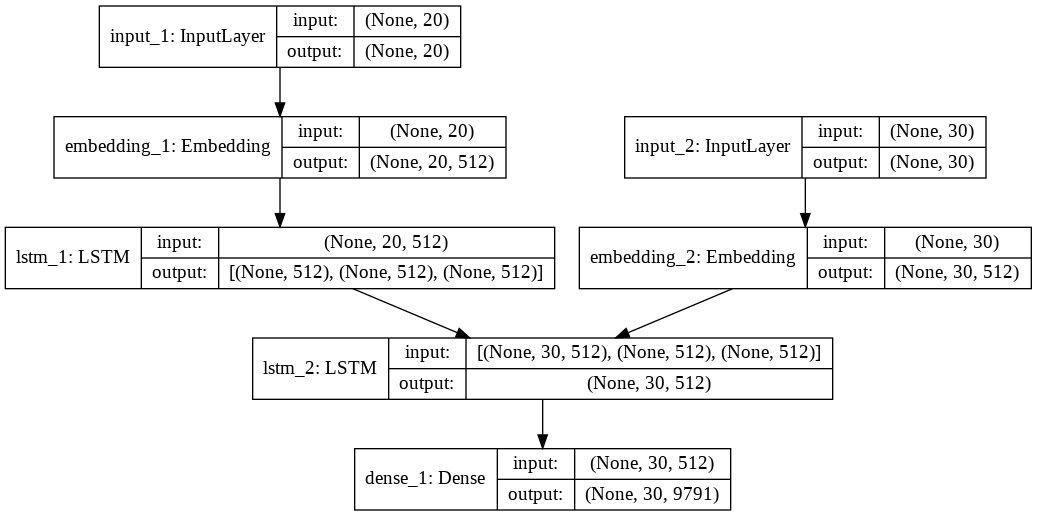

In [0]:
latent_dim = 512

encoder_inp = Input(shape=(max_length_src,))
encoder_embedding = Embedding(eng_vocab_size, latent_dim)(encoder_inp)
encoder_lstm, state_h, state_c = LSTM(latent_dim,
                            return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inp = Input(shape=(max_length_tar,))
decoder_embedding = Embedding(hin_vocab_size, latent_dim)
decoder_embedding_output = decoder_embedding(decoder_inp)
decoder_lstm = LSTM(latent_dim, return_sequences=True)
decoder_lstm_ouput = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
decoder_dense = Dense(hin_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm_ouput)
  
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inp, decoder_inp], decoder_outputs)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
batch_size = 256
filename = 'nmt.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit_generator(generator=gen_batch(train["english_sentence"], train["hindi_sentence"], batch_size), 
                    steps_per_epoch=len(train)//batch_size, 
                    validation_data = gen_batch(test["english_sentence"], test["hindi_sentence"], batch_size),
                    validation_steps = len(test)//batch_size,
                    epochs=1, 
                    verbose=1)


Epoch 1/1
16/16 [==============================] - 9s 559ms/step - loss: 40.2798 - val_loss: 59.0619


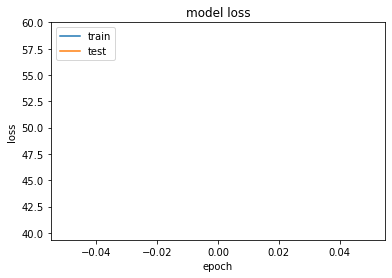

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
test = lines[5120:5200]

In [0]:
encoder_inputs = np.zeros(shape=(test.shape[0], 20), dtype="float32")
decoder_inputs = np.zeros(shape=(test.shape[0], 30), dtype="float32")  
one_hot_decoder_input = np.zeros(shape=(test.shape[0], 30, 10542), dtype="float32")

for i,sentence in enumerate(test["english_sentence"]):
    for j, word in enumerate(sentence.split()):
        encoder_inputs[i, j] = eng_char_token[word] 

for i,sentence in enumerate(test["hindi_sentence"]):
    for j, word in enumerate(sentence.split()):
        if j<len(sentence.split())-1:
            decoder_inputs[i, j] = hin_char_token[word] 
        if j>0:
            one_hot_decoder_input[i, j - 1, hin_char_token[word]] = 1

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inp, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2 = decoder_embedding(decoder_inp) # Get the embeddings of the decoder sequence
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inp] + encoder_states,
    [decoder_outputs2] + decoder_states2)

TypeError: ignored

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [0]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', train["english_sentence"][k:k+1].values[0])
print('Actual Hindi Translation:', train["hindi_sentence"][k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

In [0]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', train["english_sentence"][k:k+1].values[0])
print('Actual Hindi Translation:', train["hindi_sentence"][k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])